In [1]:
import torch
from mmcv import Config
from mmcv.parallel import MMDataParallel
from mmcv.runner import load_checkpoint, wrap_fp16_model
from mmdet3d.datasets import build_dataloader, build_dataset
from mmdet3d.models import build_detector
# from tools.analysis_tools import visual
import os
import importlib
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import cv2
import torch.nn as nn
from PIL import Image
import torch.nn.functional as F 
import matplotlib
from PIL import ImageDraw

/home/wsh/.conda/envs/jxh/lib/python3.8/site-packages/MinkowskiEngine/__init__.py:36: UserWarning: The environment variable `OMP_NUM_THREADS` not set. MinkowskiEngine will automatically set `OMP_NUM_THREADS=16`. If you want to set `OMP_NUM_THREADS` manually, please export it on the command line before running a python script. e.g. `export OMP_NUM_THREADS=12; python your_program.py`. It is recommended to set it below 24.
  warnings.warn(


In [2]:
config = '/home/wsh/xhj_ws/stream/stream_petr_seq_24e_v2_yolox_/stream_petr_seq_24e_v2_yolox_.py'
checkpoint = "/home/wsh/xhj_ws/stream/stream_petr_seq_24e_v2_yolox_/latest.pth"
cfg = Config.fromfile(config)
cfg.model.pretrained = None
cfg.data.test.test_mode = True
plugin_dir = cfg.plugin_dir
_module_dir = os.path.dirname(plugin_dir)
_module_dir = _module_dir.split('/')
_module_path = _module_dir[0]

for m in _module_dir[1:]:
    _module_path = _module_path + '.' + m
plg_lib = importlib.import_module(_module_path)

In [3]:
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)
cfg.model.train_cfg = None
model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg'))
load_checkpoint(model, checkpoint, map_location='cpu')
memory = []
hook = [model.img_roi_head.register_forward_hook(
        lambda self, input, output: memory.append(output))] #frustum
# result = []
# hook = [model.pts_bbox_head.transformer.decoder.layers[i].attentions[1].attn.register_forward_hook(
#         lambda self, input, output: result.append(output)) for i in range(6)]

load checkpoint from local path: /home/wsh/xhj_ws/stream/stream_petr_seq_24e_v2_yolox_/latest.pth


In [4]:
model = MMDataParallel(model, device_ids=[0])
model.eval()
loader = iter(data_loader)
for i in range (11):
    data = next(loader)
with torch.no_grad():
    out = model(return_loss=False, rescale=True, **data)

/home/wsh/.conda/envs/jxh/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/home/wsh/.conda/envs/jxh/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[7.1183e-06, 5.0758e-07, 1.0559e-06,  ..., 2.2705e-09, 4.4070e-09,
         3.7811e-08],
        [5.3547e-08, 1.2167e-09, 3.2118e-09,  ..., 1.6867e-05, 1.2177e-05,
         8.9092e-06],
        [8.1704e-07, 8.1093e-09, 7.5578e-09,  ..., 1.2833e-05, 4.9574e-06,
         7.0478e-06],
        ...,
        [7.0543e-06, 6.4472e-08, 1.1709e-08,  ..., 7.7458e-06, 1.0236e-05,
         1.5164e-05],
        [6.5745e-06, 8.8645e-09, 2.5990e-08,  ..., 4.8731e-06, 2.6373e-06,
         2.6999e-05],
        [2.5560e-06, 3.8035e-08, 6.8257e-09,  ..., 8.4487e-06, 1.0463e-05,
         2.6822e-05]], device='cuda:0')


In [5]:
class NormalizeInverse(torchvision.transforms.Normalize):
    #  https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/8
    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())
mean=[0.406, 0.456, 0.485]
# std=[1/255, 1/255, 1/255]
std=[58.395/255, 57.12/255, 57.375/255]
denormalize_img = torchvision.transforms.Compose((
            NormalizeInverse(mean=mean,
                             std=std),
            torchvision.transforms.ToPILImage(),
        ))

In [6]:
preds_dicts = memory[0]

In [7]:
def _bbox_decode(priors, bbox_preds):
    xys = (bbox_preds[..., :2] * priors[:, 2:]) + priors[:, :2]
    whs = bbox_preds[..., 2:].exp() * priors[:, 2:]

    tl_x = (xys[..., 0] - whs[..., 0] / 2)
    tl_y = (xys[..., 1] - whs[..., 1] / 2)
    br_x = (xys[..., 0] + whs[..., 0] / 2)
    br_y = (xys[..., 1] + whs[..., 1] / 2)

    decoded_bboxes = torch.stack([tl_x, tl_y, br_x, br_y], -1)
    return decoded_bboxes
def _centers2d_decode(priors, pred_centers2d):
    centers2d = (pred_centers2d[..., :2] * priors[:, 2:]) + priors[:, :2]
    return centers2d
def bbox_xyxy_to_cxcywh(bbox):
    """Convert bbox coordinates from (x1, y1, x2, y2) to (cx, cy, w, h).

    Args:
        bbox (Tensor): Shape (n, 4) for bboxes.

    Returns:
        Tensor: Converted bboxes.
    """
    x1, y1, x2, y2 = bbox.split((1, 1, 1, 1), dim=-1)
    bbox_new = [(x1 + x2) / 2, (y1 + y2) / 2, (x2 - x1), (y2 - y1)]
    return torch.cat(bbox_new, dim=-1)

In [8]:
from mmdet.core import MlvlPointGenerator
threshold_score = 0.4
prior_generator = MlvlPointGenerator([8, 16, 32], offset=0)
cls_scores = preds_dicts['enc_cls_scores']
bbox_preds = preds_dicts['enc_bbox_preds']
pred_centers2d_offset = preds_dicts['pred_centers2d_offset']
objectnesses = preds_dicts['objectnesses']
num_imgs = cls_scores[0].shape[0]
featmap_sizes = [cls_score.shape[2:] for cls_score in cls_scores]
mlvl_priors = prior_generator.grid_priors(
    featmap_sizes,
    dtype=cls_scores[0].dtype,
    device=cls_scores[0].device,
    with_stride=True)
num_imgs = preds_dicts['enc_cls_scores'][0].shape[0]
flatten_bbox_preds = [
    bbox_pred.permute(0, 2, 3, 1).reshape(num_imgs, -1, 4)
    for bbox_pred in bbox_preds]
flatten_objectness = [
    objectness.permute(0, 2, 3, 1).reshape(num_imgs, -1)
    for objectness in objectnesses]
flatten_centers2d_preds = [
    pred_center2d_offset.permute(0, 2, 3, 1).reshape(num_imgs, -1, 2)
    for pred_center2d_offset in pred_centers2d_offset]
valid_indices_list = []
for obj in objectnesses:
    sample_weight = obj.sigmoid()
    sample_weight_nms = nn.functional.max_pool2d(sample_weight, (3, 3), stride=1, padding=1)
    sample_weight_nms = sample_weight_nms.permute(0, 2, 3, 1).reshape(num_imgs, -1, 1)
    sample_weight_ = sample_weight.permute(0, 2, 3, 1).reshape(num_imgs, -1, 1)
    sample_weight = sample_weight_ * (sample_weight_ == sample_weight_nms).float()
    valid_indices = sample_weight > threshold_score
    valid_indices_list.append(valid_indices)
valid_indices = torch.cat(valid_indices_list, dim=1)
flatten_bbox_preds = torch.cat(flatten_bbox_preds, dim=1)
flatten_centers2d_preds = torch.cat(flatten_centers2d_preds, dim=1)
flatten_priors = torch.cat(mlvl_priors)
flatten_bboxes = _bbox_decode(flatten_priors, flatten_bbox_preds)
flatten_centers2d = _centers2d_decode(flatten_priors, flatten_centers2d_preds)
pred_bbox_list = []
pred_centers2d_list = []
for i in range(num_imgs):
    pred_bbox = flatten_bboxes[i][valid_indices[i].repeat(1, 4)].reshape(-1, 4)
    pred_centers2d = flatten_centers2d[i][valid_indices[i].repeat(1, 2)].reshape(-1, 2)
            
            # dets, _ = self._bboxes_nms(cls_scores, bboxes, score_factor, cfg)
    # bbox = bbox_xyxy_to_cxcywh(pred_bbox)
            # print(bbox)                      
    pred_bbox_list.append(pred_bbox)
    pred_centers2d_list.append(pred_centers2d)

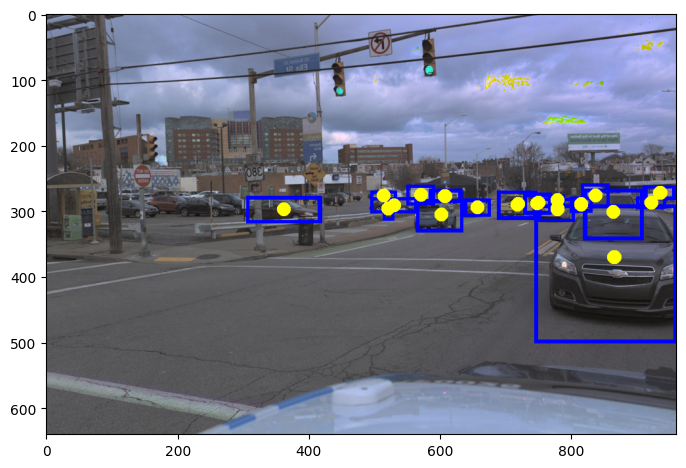

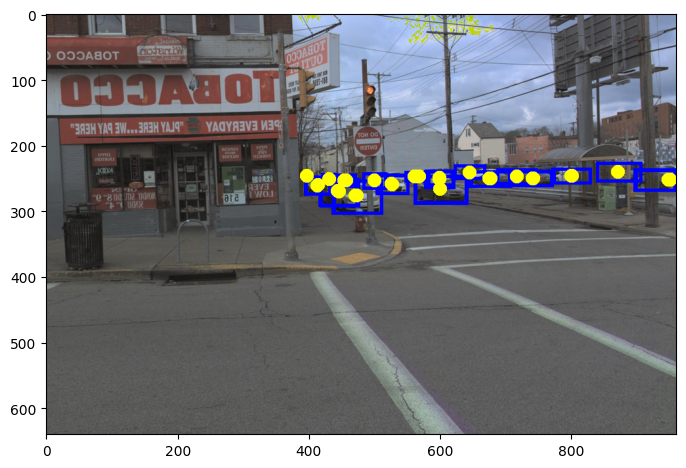

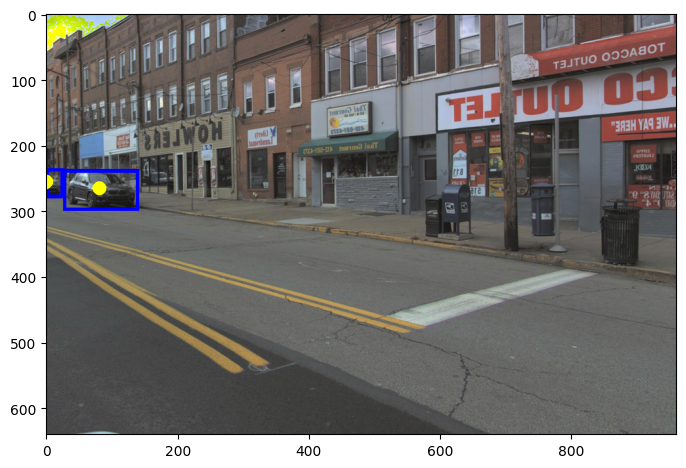

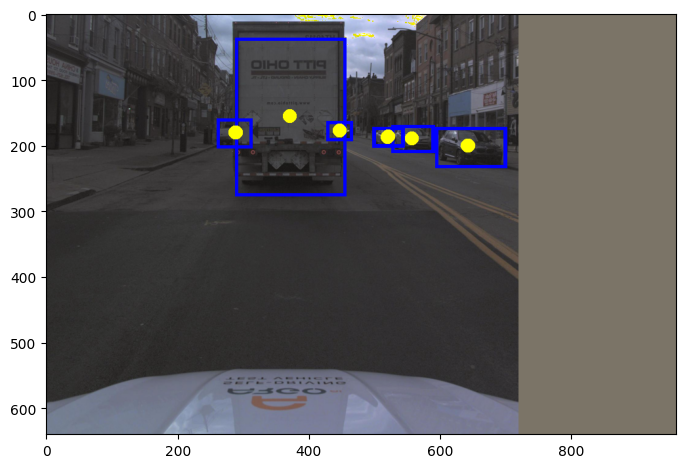

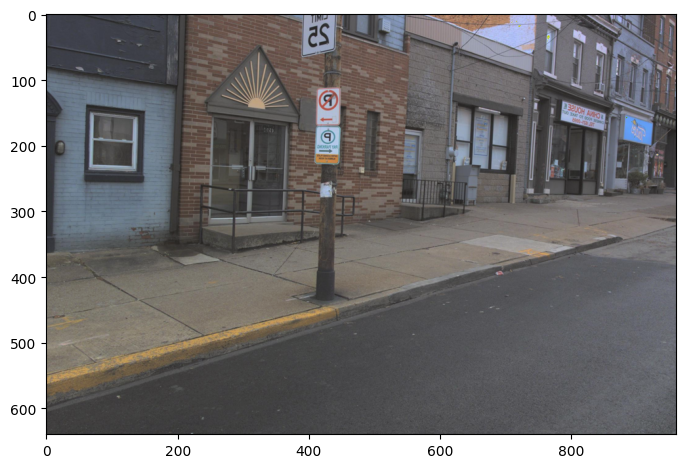

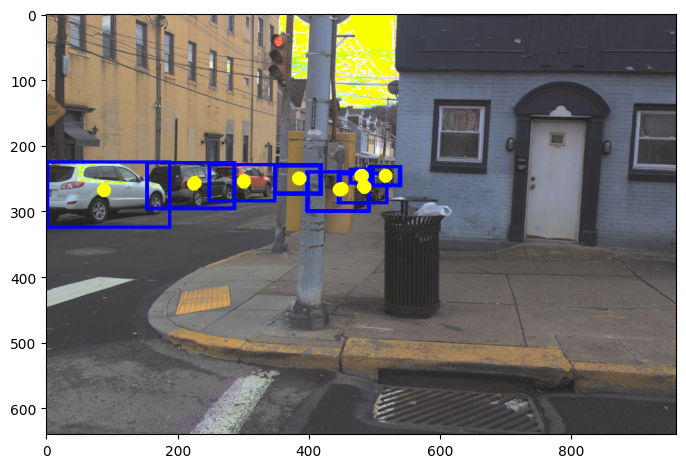

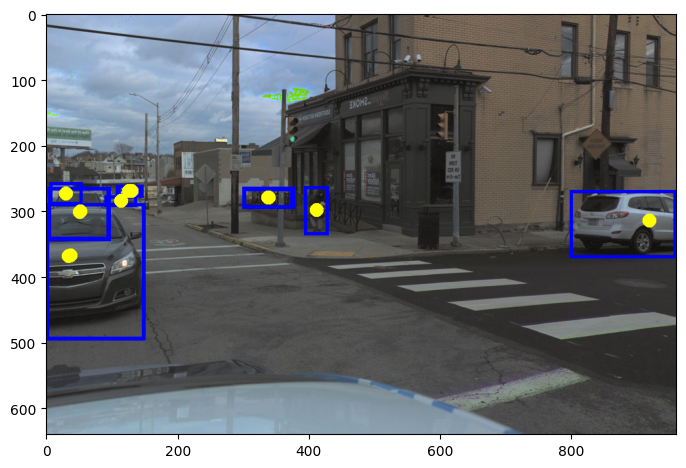

In [9]:
for i in range (7):
    plt.figure(figsize=(40, 12))
    plt.subplot(2,4,i+1)
    img = denormalize_img(data['img'][0].data[0][0][i])
    img = cv2.cvtColor(np.asarray(img),cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    pic = ImageDraw.ImageDraw(img)
    bboxes = pred_bbox_list[i]
    centers2d = pred_centers2d_list[i]
    for bbox in bboxes:
        pic.rectangle((bbox[0], bbox[1], bbox[2], bbox[3]),fill=None,outline ='blue',width =5)
    for center2d in centers2d:
        pic.ellipse((center2d[0]-10, center2d[1]-10, center2d[0]+10, center2d[1]+10), fill='yellow',)
    plt.imshow(img)
# plt.savefig("900_bboxes_cls.png")
plt.show()